# Parameter Optimization

Exhaustively search hyperparamters space for Support Vector Machine, AdaBoost and Logistic Regression classifiers.

### Get the data  from [property_calculations](property_calculations.ipynb) and test according to [algorithm_comparison](algorithm_comparison.ipynb)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import pickle

# Load property_array from property_calculations FEMA-JECFA database
BASE_DATA_PATH = path.join(path.expanduser('~'),
                           'Dropbox',
                           'bymt',
                           'data_dumps',
                           'chem_project')

dataset_path = path.join(BASE_DATA_PATH,
                         'property_calculations',
                         'dataset.pkl')

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)
    
train_features = dataset['train features']
train_labels = dataset['train labels']

### Test on different classifiers

In [103]:
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

step_list = [('imputer', Imputer(strategy='mean')),
         ('scaler', StandardScaler()),
         ('polynomial', PolynomialFeatures(2, include_bias=False)),
         ('selector', SelectPercentile(f_classif, percentile=10))]

clf_list = [GaussianNB(),
            SVC(),
            AdaBoostClassifier(),
            ExtraTreesClassifier(),
            RandomForestClassifier(),
            LogisticRegression()]

score_types = ['accuracy', 
               'precision_macro',
               'recall_macro']

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    scores_list, pipe_dict = multi_tester(step_list, clf_list, score_types)

In [64]:
test = ['1']
test.extend(['22'])
test

['1', '22']

I will focus on the Support Vector Machine, AdaBoost and Logistic Regression classifiers. They gave the highest non-optimized scores. 
To find the best one I will exhaustively search all the possible combinations of several hyper-parameters and evaluate them with cross-validation

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline 

pipe = Pipeline(steps=[('estimator', None)])

SV = SVC(random_state=42)
SV_params = {'estimator': [SV],
             'estimator__C': [1e-2, 1e-1, 1, 1e1, 1e2],
             'estimator__kernel': ['linear', 'rbf'],
             'estimator__tol': [1e-4, 5e-4, 1e-3],
             'estimator__class_weight': [None, 'balanced']}

DTC = DecisionTreeClassifier(random_state=42)
ABC = AdaBoostClassifier(base_estimator=DTC, random_state=42)
ABC_params = {'estimator': [ABC],
              'estimator__base_estimator__max_depth': [None, 3, 6, 12, 24, 48],
              'estimator__base_estimator__min_samples_leaf': [1, 2, 4, 8, 16],
              'estimator__base_estimator__class_weight': [None, 'balanced'],
              'estimator__n_estimators': [25, 50, 100, 250],
              'estimator__learning_rate': [0.01, 0.1, 1, 10]}

LR = LogisticRegression(solver='lbfgs')
LR_params = {'estimator': [LR],
             'estimator__C': [1e-2, 1e-1, 1, 1e1, 1e2],
             'estimator__class_weight': [None, 'balanced'],
             'estimator__max_iter': [100, 200],
             'estimator__tol': [1e-4, 5e-4, 1e-3],
             'estimator__warm_start': [False, True]}

all_params = [SV_params, ABC_params, LR_params]

In [82]:
from sklearn.model_selection import GridSearchCV
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    all_grid = GridSearchCV(pipe,
                           param_grid=all_params,
                           cv=4,
                           verbose=1,
                           n_jobs=-1,
                           scoring='f1')
    
    all_grid.fit(train_features, train_labels)

Fitting 4 folds for each of 1140 candidates, totalling 4560 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 738 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1189 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1994 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2753 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 3762 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 4560 out of 4560 | elapsed: 17.5min finished


Save the search results

In [184]:
grid_path = os.path.join(DATA_PATH, 'all_grid.pkl')

with open(grid_path, 'wb') as f:
    pickle.dump(all_grid, f, protocol=pickle.HIGHEST_PROTOCOL)

Analyze the search results based on:
- Raw scores
- t-test probability that they will be above the 0.3 f1 score threshhold

In [87]:
def find_top_scores(grid, class_types, cutoff=5, cv=4, verbose=False):
    """
    List the top scores from a fitted gridCV search
    
    returns list of tuples with (rank, estimator_label, test_scores, real index)
    """

    grid_results = grid.cv_results_

    score_keys = []
    end_str = '_test_score'
    start_str = 'split'
    for num in range(cv):
        complete_str = start_str+str(num)+end_str
        score_keys.append(complete_str)

    ranks = grid_results['rank_test_score']
    names_scores = []
    
    for rank in range(1,cutoff+1):
        
        idx_list = np.where(ranks == rank)[0]
        # More than one estimator can have the same rank
        for i in idx_list:
            try:
                estimator = grid_results['params'][i]['estimator']
            except KeyError:
                estimator = class_types[0][0]()
            
            for tup in class_types:
                if isinstance(estimator, tup[0]):
                    estimator_label = tup[1]
           
            test_scores = []
            for key in score_keys:
                test_scores.append(grid_results[key][i])
            
            if verbose:
                print(estimator_label)
                print np.mean(test_scores), np.std(test_scores)
            
            names_scores.append((rank, estimator_label, test_scores, i))
    
    return names_scores

In [31]:
class_types = [(SVC, 'SVC'), (AdaBoostClassifier, 'AdaBoost'), [LogisticRegression, 'LR']]
top_scores = find_top_scores(all_grid, class_types, cutoff=250)

In [33]:
import matplotlib.patches as mpatches

def plot_scores(score_list):
    """
    plots scores from score_list generated by find_top_scores
    
    score_list should be a list of tuples in the form:
    tup[0] = rank
    tup[1] = estimator label string
    tup[2] = list of scores
    tup[3] = real_index
    """
    
    ranks = [tup[0] for tup in score_list]
    labels = [tup[1] for tup in score_list]
    scores = [tup[2] for tup in score_list]
    means = [np.mean(x) for x in scores]
    deltas = [t_delta(95, x) for x in scores]
    
    plt.close('all')
    ind = len(score_list)
    fig = plt.figure(1, figsize=(10, 7), tight_layout=True)
    ax = fig.gca(title='Estimator scores',
                 xlabel='Rank',
                 xlim=[-1, ind],
                 xticks=range(ind),
                 ylabel='average score')
    bar_list = ax.bar(range(ind), means, yerr=deltas, align='center')
    ax.set_xticklabels(ranks)
    ax.hlines(0.3, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dashed', colors='r')
    # color bar based on label selected features red
    color_dict = {'AdaBoost': 'b',
                  'SVC': 'g',
                  'LR': 'm'}
    for i, name in enumerate(labels):
        bar_list[i].set_color(color_dict[name])
        
    # create custom legend
    blue_patch = mpatches.Patch(color='blue', label='Adaboost')
    green_patch = mpatches.Patch(color='green', label='SVC')
    magenta_patch = mpatches.Patch(color='magenta', label='LR')
    plt.legend(handles=[blue_patch, green_patch, magenta_patch])
    plt.show()

/Users/TRN/anaconda/envs/ml27/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


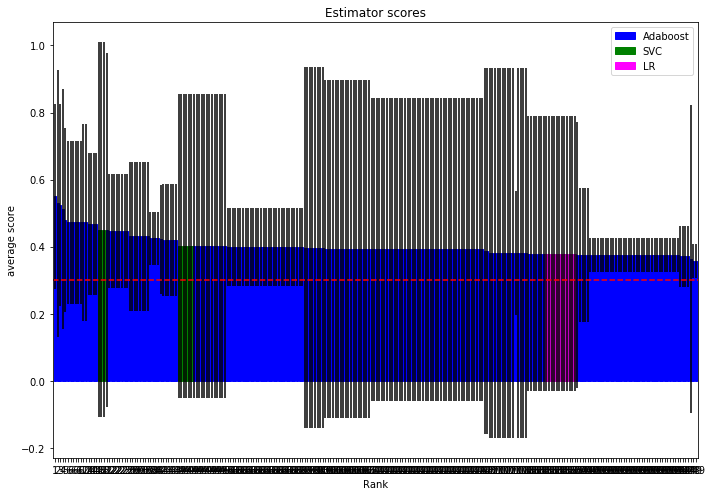

In [34]:
plot_scores(top_scores)

The most highly ranked estimators also have a very large confidence interval. I would rather focus on slightly lower scores that are more likely to be above the 0.3 f1 score threshold. Will use t-test statistics to determine the best estimator based on that.

In [37]:
from scipy.stats import variation

def t_score(score, cutoff=0.3):
    mean, sem = np.mean(score), st.sem(score)
    val = st.t.cdf(0.3, len(score)-1, loc=mean, scale=sem)
    return val

def rank_by_t_score(score_list):
    """
    sorts score list by t-score
    
    score_list should be a list of tuples in the form:
    tup[0] = rank
    tup[1] = estimator label string
    tup[2] = list of scores
    tup[3] = real_index
    """
    ranks = [tup[0] for tup in score_list]
    labels = [tup[1] for tup in score_list]
    scores = [tup[2] for tup in score_list]
    real_is = [tup[3] for tup in score_list]
    ts = [t_score(score) for score in scores]
    
    all_list = zip(ranks, labels, scores, real_is, ts)
    
    all_list = sorted(all_list, key=lambda tup: tup[4])
    all_list = [tup[:4] for tup in all_list]
    
    return all_list

In [38]:
top_scores_t = rank_by_t_score(top_scores)

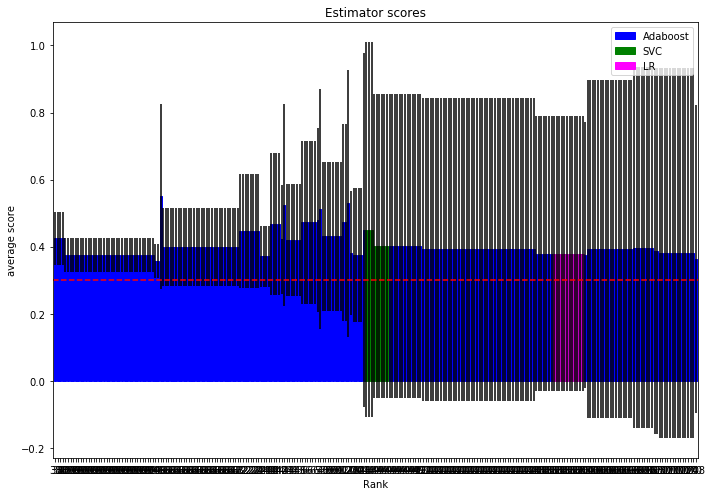

In [39]:
plot_scores(top_scores_t)

In [62]:
result_params = all_grid.cv_results_['params']
top_t_cv_idxs = [tup[3] for tup in top_scores_t[:10]]

def list_params(params, idxs):
    constants = []
    variables = []
    keys = params[idxs[0]].keys()
    keys.remove('estimator')
    
    for key in keys:
        temp_list = []
        for i in idxs:
            temp_list.append(params[i][key])
            set_list = set(temp_list)
        if len(set_list) == 1:
            constants.append((key, set_list))
        else:
            variables.append((key, temp_list))

    print 'CONSTANTS:'
    for cons in constants:
        print cons[0], cons[1]
    
    print 'VARIABLES:'
    for var in variables:
        print var[0], var[1]

In [63]:
list_params(result_params, top_t_cv_idxs)

CONSTANTS:
estimator__base_estimator__class_weight set(['balanced'])
VARIABLES:
estimator__learning_rate [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 1, 1]
estimator__base_estimator__max_depth [3, 3, 3, 3, None, None, None, None, None, None]
estimator__base_estimator__min_samples_leaf [1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
estimator__n_estimators [25, 50, 100, 250, 25, 50, 100, 250, 25, 50]


Looks like AdaBoostClassifier is most likely to perform best when:
- base estimator `class_weight` is 'balanced'
- base estimator `max_depth` is 3 or None
- base estimator `min_samples_leaf` is 1 or 2
- `learning_rate` is 0.01 or 1

- `n_estimators` can be any of the values tested, so will stick to the lowest: 25

Confirm that the best estimator does, in fact perform well on the test features. If it does it indicates that the training process has not resulted in an overfit estimator

In [97]:
best = result_params[top_t_cv_idxs[0]]['estimator']
best.fit(train_features, train_labels)
pred = best.predict(test_features)
print classification_report(pred, test_labels)

             precision    recall  f1-score   support

        0.0       1.00      0.91      0.95        57
        1.0       0.38      1.00      0.55         3

avg / total       0.97      0.92      0.93        60



Looks good!

### Dump classifier, dataset, and features_list so that results can be tested using the course tester function in the [summary](summary.ipynb) notebook

In [109]:
import tools.tester

dump_classifier_and_data(best, final_data, final_names)